In [1]:
from fastai.collab import *
from fastai.tabular import *
import sqlite3

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [2]:
user,item,title = 'userId','movieId','title'

In [3]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/home/ubuntu/.fastai/data/movie_lens_sample')

In [4]:
# artists = pd.read_csv(path/'artists.csv')
con = sqlite3.connect("pitchfork.sqlite")
reviews = pd.read_sql_query("SELECT * from reviews", con)
reviews.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017
4,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017


That's all we need to create and train a model:

In [6]:
data = CollabDataBunch.from_df(reviews, seed=42)

SyntaxError: invalid syntax (<ipython-input-6-982ee2545137>, line 1)

In [8]:
TabularList??

In [6]:
y_range = [0,5.5]

In [7]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [8]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.617061,0.951438,00:04
1,0.848545,0.678562,00:00
2,0.650997,0.662788,00:00


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [14]:
path=Config.data_path()/'ml-100k'

In [15]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [16]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [17]:
len(ratings)

100000

In [18]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [19]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [20]:
data.show_batch()

userId,title,target
219,Ulee's Gold (1997),4.0
453,Star Trek VI: The Undiscovered Country (1991),3.0
297,"Professional, The (1994)",4.0
838,Searching for Bobby Fischer (1993),4.0
653,"Empire Strikes Back, The (1980)",3.0


In [21]:
y_range = [0,5.5]

In [22]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


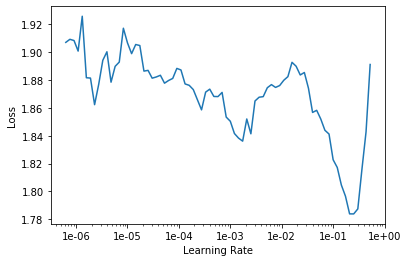

In [23]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [27]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.576978,0.858051,00:07
1,0.684169,0.860717,00:07
2,0.590798,0.853804,00:07
3,0.487573,0.849521,00:07
4,0.376607,0.852195,00:07


In [28]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [29]:
learn.load('dotprod');

In [30]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [31]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [32]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [33]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [34]:
item0 = lambda o:o[0]

In [35]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.4934),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.4715),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.4188), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.4134), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.3785), 'Grease 2 (1982)', 2.0),
 (tensor(-0.3779), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.3650), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.3650), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.3599), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.3560), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.3458), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.3374), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.3136), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.3035), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.3016), "McHale's Navy (199

In [36]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.7593), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.7573), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.7224), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.7133), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.7040), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.6783), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.6704), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.6649), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.6617), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.6423), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.6408), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.6385), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.6143), 'Apt Pupil (1998)', 4.1),
 (tensor(0.6107), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.6107), 'Vertigo (1958)', 4.251396648044692)]

### Movie weights

In [37]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [38]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [39]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [40]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.0988), 'Jungle2Jungle (1997)'),
 (tensor(1.0626), 'Home Alone 3 (1997)'),
 (tensor(0.9221), 'Batman & Robin (1997)'),
 (tensor(0.8930), 'Batman Forever (1995)'),
 (tensor(0.8926), "Dante's Peak (1997)"),
 (tensor(0.8860), 'Bio-Dome (1996)'),
 (tensor(0.8800), 'Murder at 1600 (1997)'),
 (tensor(0.8750), "McHale's Navy (1997)"),
 (tensor(0.8706), 'D3: The Mighty Ducks (1996)'),
 (tensor(0.8642), 'Congo (1995)')]

In [41]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.0321), 'Chinatown (1974)'),
 (tensor(-1.0017),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(-0.9896), 'When We Were Kings (1996)'),
 (tensor(-0.9615), 'Ran (1985)'),
 (tensor(-0.9144), 'Lawrence of Arabia (1962)'),
 (tensor(-0.9120), 'Big Sleep, The (1946)'),
 (tensor(-0.8826), 'Casablanca (1942)'),
 (tensor(-0.8804), 'Paths of Glory (1957)'),
 (tensor(-0.8717), 'Wrong Trousers, The (1993)'),
 (tensor(-0.8682), 'Apocalypse Now (1979)')]

In [42]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [43]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2169), 'Braveheart (1995)'),
 (tensor(1.1447), 'Raiders of the Lost Ark (1981)'),
 (tensor(1.0938), 'Titanic (1997)'),
 (tensor(0.9568), "It's a Wonderful Life (1946)"),
 (tensor(0.9355), 'Forrest Gump (1994)'),
 (tensor(0.8550), 'Back to the Future (1985)'),
 (tensor(0.8446), 'Star Wars (1977)'),
 (tensor(0.8415), 'Field of Dreams (1989)'),
 (tensor(0.8319), 'Empire Strikes Back, The (1980)'),
 (tensor(0.8048), 'Return of the Jedi (1983)')]

In [44]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.8479), 'Stupids, The (1996)'),
 (tensor(-0.8013), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(-0.7459), 'Keys to Tulsa (1997)'),
 (tensor(-0.7197), 'Dracula: Dead and Loving It (1995)'),
 (tensor(-0.7196), 'Dead Man (1995)'),
 (tensor(-0.6940), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(-0.6906), 'Crash (1996)'),
 (tensor(-0.6520), "McHale's Navy (1997)"),
 (tensor(-0.6515), 'Cabin Boy (1994)'),
 (tensor(-0.6425), 'Jude (1996)')]

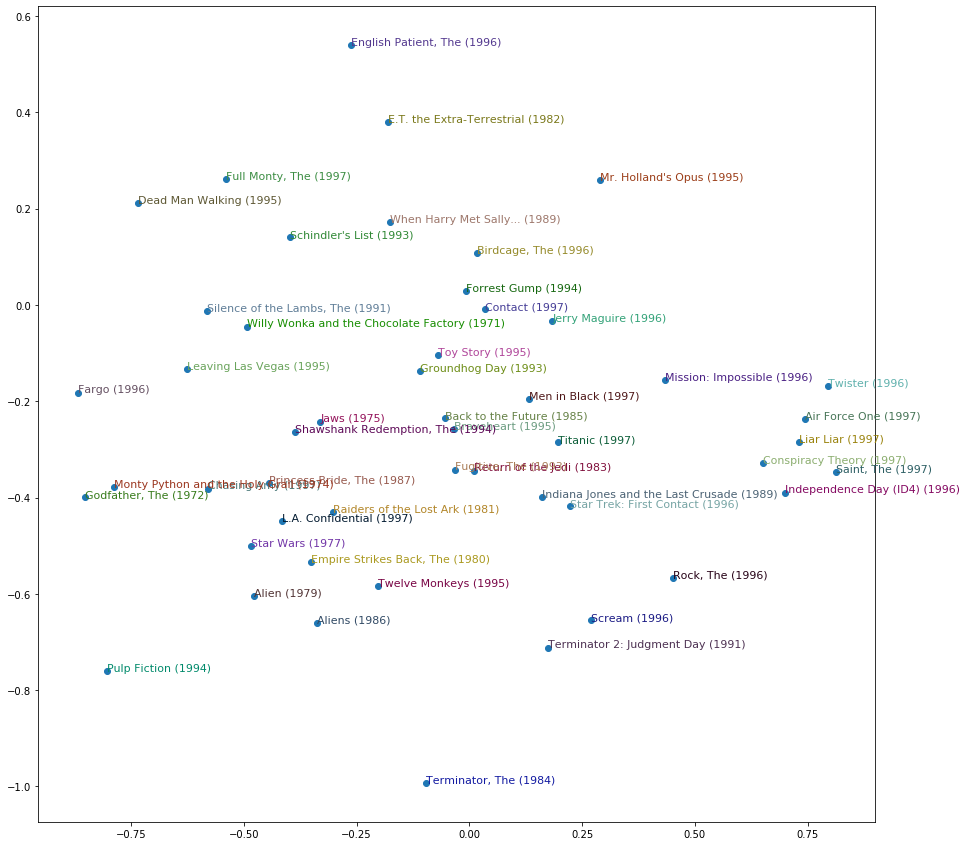

In [45]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()